## 1. About Dataset

### 1.1. Source & Acknowledgements

### 1.2. Content

### 1.3. Task

### 1.4. Data description

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import warnings
warnings.filterwarnings('ignore')

In [10]:
sj = pd.read_csv('D:/ML/us-software-engineer-jobs-zenrows.csv')

In [11]:
sj.head()

,title,company,salary,rating,review_count,types,location,relative_time,hires_needed,hires_needed_exact,...,indeed_applyable,ad_id,remote_location,source_id,hiring_event_job,indeed_apply_enabled,job_location_postal,company_overview_link,activity_date,location_extras
0,Android Developer,Shockoe,NaN,0.0,0,Full-time,"Richmond, VA",30+ days ago,NaN,NaN,...,False,NaN,False,11706594,False,False,NaN,NaN,NaN,NaN
1,Web Developer,"Denios, Inc.","$45,000 - $55,000 a year",0.0,0,Full-time,"Louisville, KY",30+ days ago,ONE,1,...,True,370154371.0,False,11468052,False,True,40219.0,NaN,Active 2 days ago,NaN
2,Sr. Android Developer,The Cervantes Group,NaN,4.1,22,Full-time,Remote,6 days ago,TWO_FOUR,2,...,True,NaN,False,9570478,False,True,NaN,/cmp/The-Cervantes-Group,Active 3 days ago,NaN
3,Junior Software Engineer,Medical Knowledge Group,NaN,0.0,0,Full-time,Remote,8 days ago,ONE,1,...,True,368864426.0,False,501562,False,True,NaN,NaN,Active 3 days ago,NaN
4,"Cloud Engineer (Software Engineer Advanced, Ex...",Federal Reserve Bank of New York,NaN,4.1,548,Full-time,"Kansas City, MO",2 days ago,NaN,NaN,...,False,NaN,False,1439,False,False,NaN,/cmp/Federal-Reserve-Bank-of-New-York,NaN,NaN


## 2. Data visualization and cleaning

The data cleaning process will ensure that our dataset is accurate and suitable for analysis. We will:

* Remove any duplicate entries to prevent skewing the results.
*Standardize salary information for consistency and easier comparison.
* Convert text-based categorical data into a numeric format where appropriate.
* Handle missing values intelligently based on the context of the data.

In [12]:
# Define a function to standardize the salary data
def standardize_salary(salary_str):
    if pd.isna(salary_str) or salary_str.strip() == "":
        return None  # Keep NaN or empty string values as None for now
    
    try:
        # Remove the dollar signs and commas, and strip whitespace
        salary_str = salary_str.replace('$', '').replace(',', '').strip()

        # Define multipliers for different time periods
        hourly_multiplier = 40 * 52  # 40 hours/week * 52 weeks/year
        daily_multiplier = 260  # 5 days/week * 52 weeks/year
        monthly_multiplier = 12  # 12 months/year
        
        # Initialize the salary value
        salary_value = None

        # Handle different cases of salary strings
        if '-' in salary_str:  # Range values
            low, high = salary_str.split('-')[0].strip(), salary_str.split('-')[1].strip()
            low_value = float(low.split(' ')[0])
            high_value = float(high.split(' ')[0])
            salary_value = (low_value + high_value) / 2  # Average of range

            # Determine the multiplier based on the period (year, month, day, hour)
            if 'year' in low:
                pass  # No multiplier needed for annual salary
            elif 'month' in low:
                salary_value *= monthly_multiplier
            elif 'day' in low:
                salary_value *= daily_multiplier
            elif 'hour' in low:
                salary_value *= hourly_multiplier

        elif 'From' in salary_str:  # Minimum values
            salary_value = float(salary_str.split(' ')[1])
            if 'year' in salary_str:
                pass  # No multiplier needed for annual salary
            elif 'month' in salary_str:
                salary_value *= monthly_multiplier
            elif 'day' in salary_str:
                salary_value *= daily_multiplier
            elif 'hour' in salary_str:
                salary_value *= hourly_multiplier

        elif 'Up to' in salary_str:  # Maximum values
            salary_value = float(salary_str.split(' ')[2])
            if 'year' in salary_str:
                pass  # No multiplier needed for annual salary
            elif 'month' in salary_str:
                salary_value *= monthly_multiplier
            elif 'day' in salary_str:
                salary_value *= daily_multiplier
            elif 'hour' in salary_str:
                salary_value *= hourly_multiplier

        else:  # Single values
            salary_value = float(salary_str.split(' ')[0])
            if 'year' in salary_str:
                pass  # No multiplier needed for annual salary
            elif 'month' in salary_str:
                salary_value *= monthly_multiplier
            elif 'day' in salary_str:
                salary_value *= daily_multiplier
            elif 'hour' in salary_str:
                salary_value *= hourly_multiplier

        return salary_value

    except (ValueError, IndexError):
        # In case of conversion error or improperly formatted string, return None
        return None

# Apply the standardized salary function to the salary column
sj['salary_standardized'] = sj['salary'].apply(standardize_salary)

In [16]:
# Drop  the standardized salaries with missing values
sj.dropna(subset=['salary_standardized'], inplace=True)

# Extract the number of days since the job was posted from 'relative_time'
sj['days_posted'] = sj['relative_time'].str.extract('(\d+)').astype(float)

# Categorize job as 'Remote' or 'Onsite' based on the 'location' column
sj['job_type'] = np.where(sj['location'].str.contains('Remote', case=False, na=False), 'Remote', 'Onsite')

# Check for missing values and handle them appropriately
missing_values = sj.isnull().sum()

# Remove any duplicate rows in the dataset
sj = sj.drop_duplicates()

# Filter out developer and engineer jobs for further analysis
developer_jobs = sj[sj['title'].str.contains('Developer', case=False, na=False)]
engineer_jobs = sj[sj['title'].str.contains('Engineer', case=False, na=False)]

# Calculate the average salary for Developer jobs
developer_avg_salary = developer_jobs['salary_standardized'].mean()

# Calculate the average salary for Engineer jobs
engineer_avg_salary = engineer_jobs['salary_standardized'].mean()

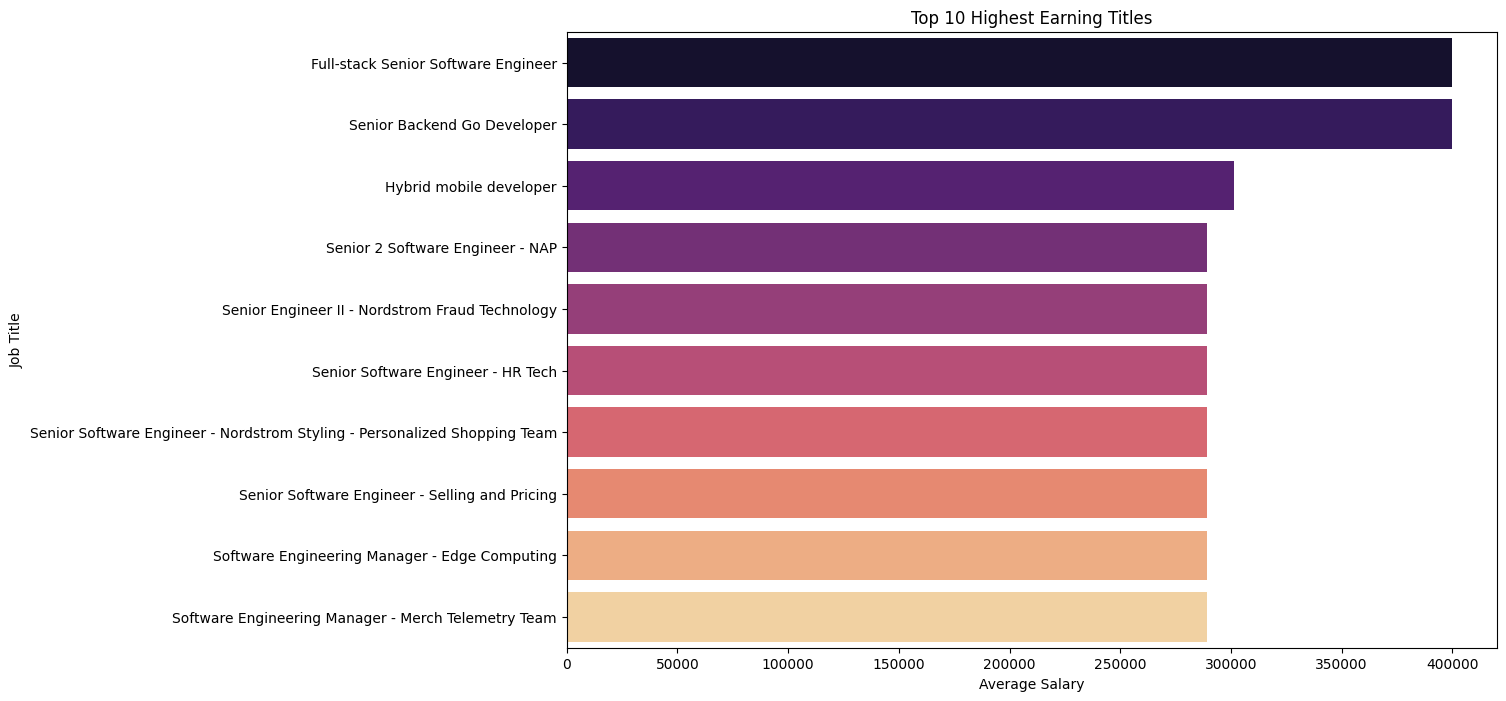

In [17]:
# Limit to top 10 titles
plt.figure(figsize=(12, 8))
top_titles = sj.groupby('title')['salary_standardized'].mean().nlargest(10)
sns.barplot(y=top_titles.index, x=top_titles.values, palette='magma')
plt.title('Top 10 Highest Earning Titles')
plt.xlabel('Average Salary')
plt.ylabel('Job Title')
plt.show()

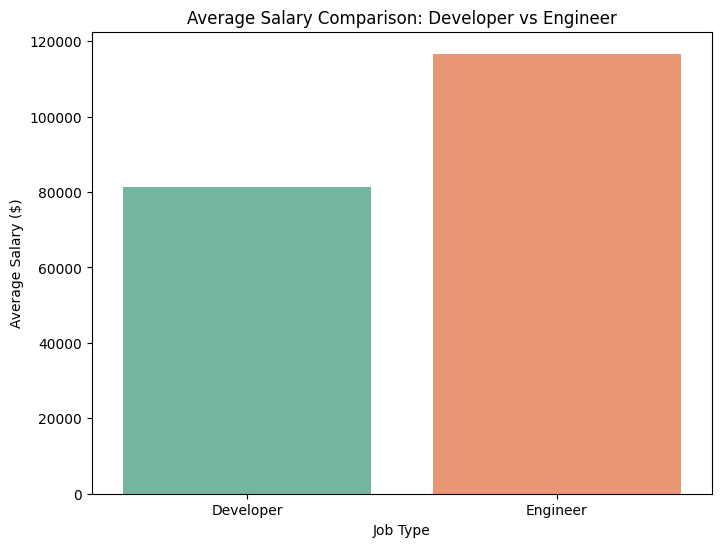

In [18]:
# Data for plotting
average_salaries = pd.DataFrame({
    'Job Type': ['Developer', 'Engineer'],
    'Average Salary': [developer_avg_salary, engineer_avg_salary]
})

# Plotting
plt.figure(figsize=(8, 6))
sns.barplot(x='Job Type', y='Average Salary', data=average_salaries, palette='Set2')
plt.title('Average Salary Comparison: Developer vs Engineer')
plt.ylabel('Average Salary ($)')
plt.show()

### How do the job's salary correlate to onsite/remote?

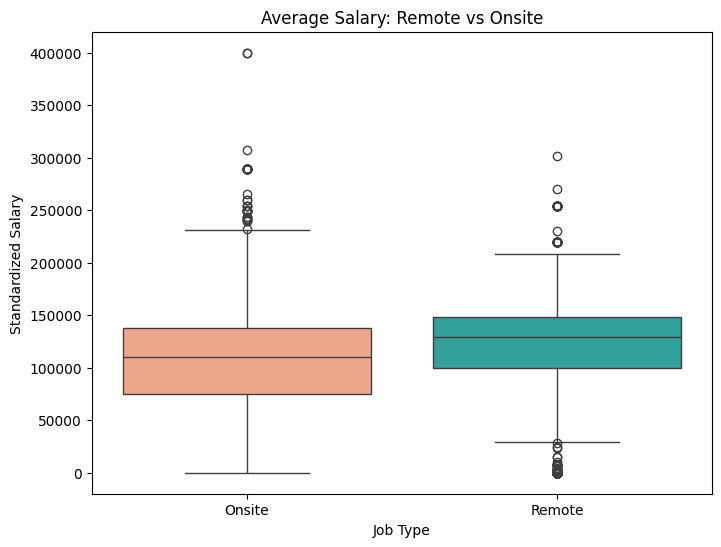

In [19]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='job_type', y='salary_standardized', data=sj, palette=['#FFA07A', '#20B2AA'])
plt.title('Average Salary: Remote vs Onsite')
plt.xlabel('Job Type')
plt.ylabel('Standardized Salary')
plt.show()

### Top 10 Highest Earning Titles

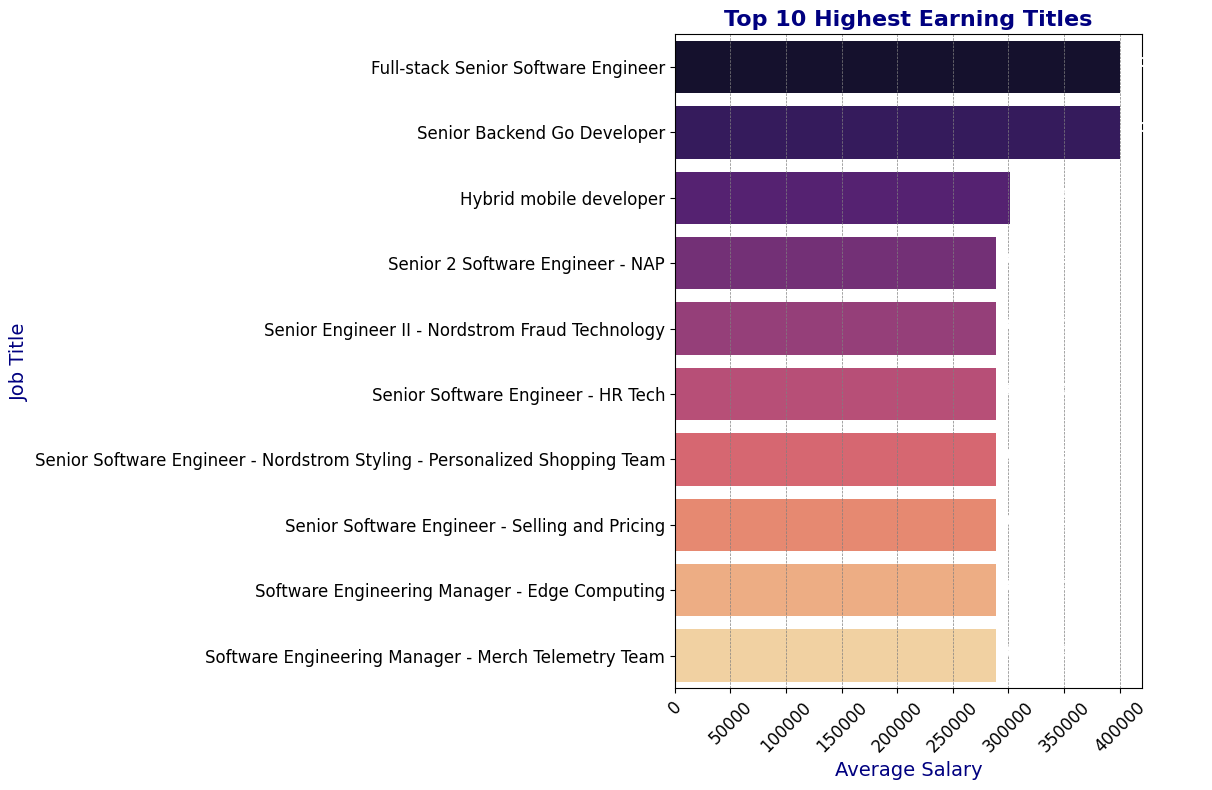

In [20]:
plt.figure(figsize=(12, 8))
top_titles = sj.groupby('title')['salary_standardized'].mean().nlargest(10)
sns.barplot(y=top_titles.index, x=top_titles.values, palette='magma')

# Adding value annotations on each bar
for index, value in enumerate(top_titles.values):
    plt.text(value, index, f'{value:.2f}', color='white', fontweight='bold')

plt.title('Top 10 Highest Earning Titles', fontsize=16, fontweight='bold', color='navy')
plt.xlabel('Average Salary', fontsize=14, color='navy')
plt.ylabel('Job Title', fontsize=14, color='navy')
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.grid(axis='x', linestyle='--', linewidth=0.5, color='grey')
plt.tight_layout()
plt.show()

### Average Salary Comparison: Developer vs Engineer

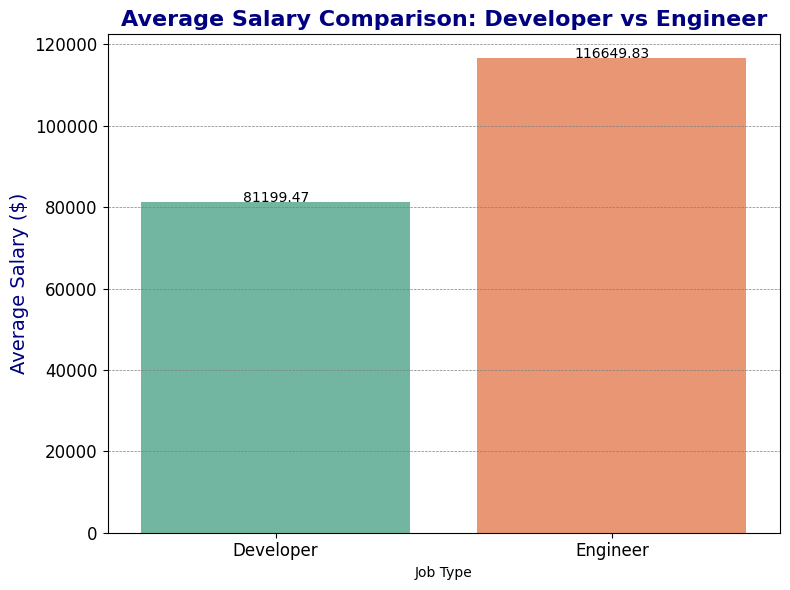

In [21]:
plt.figure(figsize=(8, 6))
sns.barplot(x='Job Type', y='Average Salary', data=average_salaries, palette='Set2')

# Adding value annotations on each bar
for index, row in average_salaries.iterrows():
    plt.text(row.name, row['Average Salary'], f'{row["Average Salary"]:.2f}', color='black', ha="center")

plt.title('Average Salary Comparison: Developer vs Engineer', fontsize=16, fontweight='bold', color='navy')
plt.ylabel('Average Salary ($)', fontsize=14, color='navy')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', linewidth=0.5, color='grey')
plt.tight_layout()
plt.show()

### Average Salary: Remote vs Onsite

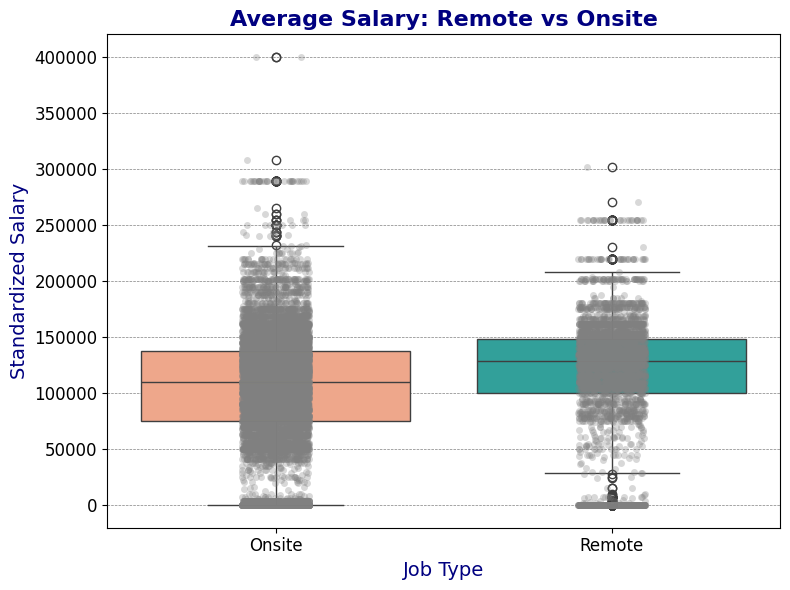

In [22]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='job_type', y='salary_standardized', data=sj, palette=['#FFA07A', '#20B2AA'])

# Adding individual data points
sns.stripplot(x='job_type', y='salary_standardized', data=sj, color='grey', alpha=0.3)

plt.title('Average Salary: Remote vs Onsite', fontsize=16, fontweight='bold', color='navy')
plt.xlabel('Job Type', fontsize=14, color='navy')
plt.ylabel('Standardized Salary', fontsize=14, color='navy')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', linewidth=0.5, color='grey')
plt.tight_layout()
plt.show()